In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
%cd /home/pengyu.zhang/project/superres/ProbSR/Experiment3

/home/pengyu.zhang/project/superres/ProbSR/Experiment3


In [3]:
from data_generation import *
from scipy.linalg import sqrtm
from downscaling import *
from utils import *
import random
import scipy.ndimage

In [4]:
%cd Bicubic_Downsampling/

/home/pengyu.zhang/project/superres/ProbSR/Experiment3/Bicubic_Downsampling


### Upscale by 4

In [5]:
N_low = 15
N_high = 60
scale = 4
a, b, c, d = 1,1,1,0

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)
z_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)
z_high = np.arange(0,1.0001,h_high)

In [6]:
w_low, r_low, A_low, x_low, y_low, z_low = generate_data(N_low,a,b,c,d)
w_high, r_high, A_high, x_high, y_high, z_high = generate_data(N_high,a,b,c,d)

/home/pengyu.zhang/project/superres/ProbSR/Experiment3/data_generation.py:131: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  w = linalg.spsolve(A,r).reshape((N,N,N))


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for prior variance
prior_sigma = 0.0001
ll_sigma = 0.001

In [8]:
operator = (A_high.T) * (1/prior_sigma**2)
b_high = create_forcing_term(N_high,a,b,c,d)

In [75]:
G = DownScale3D(1,16).to(device)
G.load_state_dict(torch.load('/home/pengyu.zhang/project/superres/ProbSR/Experiment3/Bicubic_Downsampling/models/model2/15_60/lr0.001_gamma0.5_stepsize100_K2500_llsigma_0.001_psigma0.0001/ckpt/current_epoch.pth')['netG'])

<All keys matched successfully>

In [76]:
w_high_tensor = torch.tensor(w_high).to(torch.float32).to(device)
w_low_tensor = torch.tensor(w_low).to(torch.float32).to(device)
downscaled = F.interpolate(w_high_tensor.reshape(1,1,N_high,N_high,N_high),(N_low,N_low,N_low)).reshape(N_low,N_low,N_low)
out = G(w_high_tensor.reshape(1,N_high,N_high,N_high))
residual = w_low_tensor-downscaled

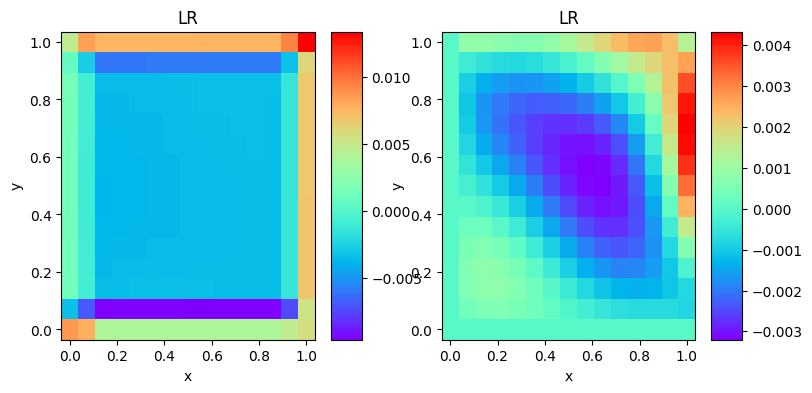

In [77]:
fig = plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_low, y_low, out.cpu().data.numpy()[0][4], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(-0.004, 0.004)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,2,2)
plt.pcolormesh(x_low, y_low, residual.cpu().data.numpy()[4], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [66]:
# Parameters for Langevin dynamics
K = 3000
s = 0.00001

x = torch.tensor(w_low).to(torch.float32).to(device)
chains_evolution = []
# z = F.interpolate(x.reshape(1,1,N_low,N_low,N_low),(N_high,N_high,N_high),mode='trilinear').reshape(N_high,N_high,N_high)
SR = scipy.ndimage.zoom(w_low, [4,4,4], order=3)
z = torch.tensor(SR).to(torch.float32).to(device)
z = z.clone().detach().requires_grad_(True)

for i in range(K):
    # Grad log-likelihood
    downscaled = F.interpolate(w_high_tensor.reshape(1,1,N_high,N_high,N_high),(N_low,N_low,N_low)).reshape(N_low,N_low,N_low)
    x_hat = downscaled + G(z.reshape(1,N_high,N_high,N_high)).reshape(N_low,N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**3),(x-x_hat).reshape(N_low**3,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]

    # Grad prior
    difference = A_high.dot(z.cpu().data.numpy().reshape(N_high**3,1)) - b_high.reshape(N_high**3,1)
    grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high,N_high)
    grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32).to(device)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high,N_high]).to(device)
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W
    
    if i > K-10:
        chains_evolution.append(z.cpu().data.numpy())   

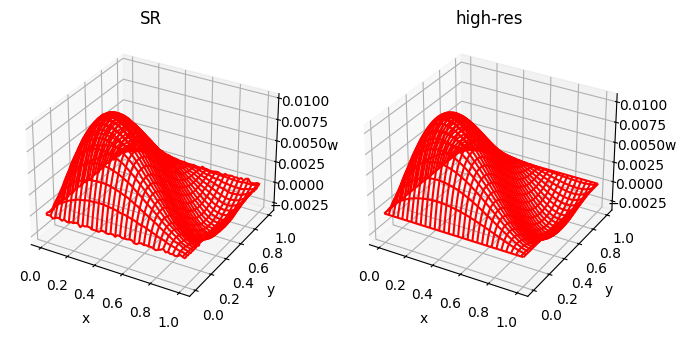

In [67]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy()[4],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high[4],color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [69]:
error1 = abs(w_high - np.mean(chains_evolution,axis=0))
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

SR L2 Error: 1.0955726414588758e-06


In [23]:
z.cpu().data.numpy()[4].max()

0.006864019

In [24]:
w_high[4].max()

0.01070046695606601

In [22]:
error1 = abs(w_high - z.cpu().data.numpy())
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

SR L2 Error: 0.0001036994474991034
